<a href="https://colab.research.google.com/github/saimani5/Notebooks_for_papers/blob/main/SlidingTransform_BaTiO3_Temperature_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

July 1, 2020
- data by Vaso Tileli and Reinis Ignatas, EPFL
- notebook by Mani Valleti
- workflow by Sergei Kalinin

# Import and download stuff

In [1]:
#@title Download AtomAI and Import Libraries
!pip install git+https://github.com/ziatdinovmax/atomai.git@dev


import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde

import seaborn as sns
from tqdm import tqdm
from atomai import utils

from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/ziatdinovmax/atomai.git (to revision dev) to /tmp/pip-req-build-gds59m3t
  Running command git clone -q https://github.com/ziatdinovmax/atomai.git /tmp/pip-req-build-gds59m3t
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
     |████████████████████████████████| 184kB 13.2MB/s 
     |████████████████████████████████| 1.0MB 17.6MB/s 
     |████████████████████████████████| 870kB 55.2MB/s 
  Created wheel for atomai: filename=atomai-0.5.2-cp37-none-any.whl size=77533 sha256=52868ec867fecf5a69bc35b2425b2d24178eca5a260d4d306b5dcb79fef444f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-9y3_7erj/wheels/05/98/11/653e332c426b2a7cf02d3bf22b8b9d4c8e8964c69b16549378
Successfully built atomai
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.6.1
    Uninstalli

Mounted at /content/drive


In [2]:
#@title  Class for analysis and Function for KDE
class Tileli_analysis:

  def __init__(self, images_input, num_subimgs = 100, window_size = 24,
               transformation = 'fft', theta_points = 30, decomposition = 'nmf', n_comp = 3):
    
    self.images_input = images_input
    self.num_subimgs = num_subimgs
    self.window_size = window_size
    self.transformation = transformation
    self.decomposition = decomposition
    self.n_comp = n_comp
    self.img_dim = window_size

    if self.transformation == 'radon':
      self.theta_points = theta_points
      self.img_dim = theta_points

    self.img_data = pd.DataFrame()


  def encode(self):
    self.imstack, com_all, frames_all = utils.extract_random_subimages(self.images_input, self.window_size, num_images = self.num_subimgs)
    self.imstack = self.imstack[..., 0] # disregard channel dimension for grayscale data
    frame_num = np.arange(len(self.images_input))
    self.img_data['Frame'] = frames_all
    self.img_data['time'] = np.nan
    self.img_data['temperature'] = np.nan
    self.img_data['com_1'] = com_all[:,0]
    self.img_data['com_2'] = com_all[:,1]

    for i in range((self.images_input).shape[0]):
      self.img_data['time'][self.num_subimgs*i:self.num_subimgs*(i+1)] = np.ones(self.num_subimgs)*dat[int(frame_num[i]),0]
      self.img_data['temperature'][self.num_subimgs*i:self.num_subimgs*(i+1)] = np.ones(self.num_subimgs)*dat[int(frame_num[i]),1]


    print('Applying tansformations\n')

    # Transformation block
    if self.transformation == 'fft':
      transformed_mat = self.do_fft(self.imstack)

    elif self.transformation == 'radon':
      transformed_mat = self.do_radon(self.imstack, self.theta_points)
    
    elif self.transformation == 'identity':
      transformed_mat = self.do_identity(self.imstack)

    else:
      raise NotImplementedError("Choose between 'fft', 'radon', and 'identity' transformations")

    # Decomposition block
    print('Applying linear unmixing techniques')
    if self.decomposition == 'pca':
      self.weights, self.pca_exp_var_ratio = self.do_pca(transformed_mat, nc = self.n_comp)
    
    elif self.decomposition == 'nmf':
      self.weights, self.nmf_error = self.do_nmf(transformed_mat, nc = self.n_comp)

    else:
      raise NotImplementedError("Choose between 'pca', 'nmf' for decomposition")

    
    return 'Encoding Done'

  def decode(self, frame_num = 25, batch_update = False, num_of_frames = 2, stride = 4):

    self.batch_update = batch_update
    self.stride = stride

    if self.batch_update:
      self.num_of_frames = num_of_frames
      self.frame_num = np.linspace(0, (self.images_input).shape[0]-1, self.num_of_frames).astype(int)
      self.images_selected = images[self.frame_num]
      
    
    elif not(self.batch_update):
      self.num_of_frames = 1
      self.frame_num = frame_num
      self.images_selected = self.images_input[self.frame_num]

    slided_imgs, num = self.make_sliding_subimgs()
    

    print('Applying tansformations\n')

    # Transformation block
    if self.transformation == 'fft':
      trans_slided_mat = self.do_fft(slided_imgs)

    elif self.transformation == 'radon':
      trans_slided_mat = self.do_radon(slided_imgs, self.theta_points)
    
    elif self.transformation == 'identity':
      trans_slided_mat = self.do_identity(slided_imgs)

    decoded = np.matmul(trans_slided_mat, np.transpose(self.weights))

    self.decoded = decoded.reshape([self.num_of_frames, num, num, self.n_comp])
    

    return 'Decoding Done'
    


  def do_fft(self, imgs):
    img_size_1 = np.shape(imgs)[1]
    img_size_2 = np.shape(imgs)[2]
    fft = np.zeros([len(imgs), img_size_1, img_size_2])
    from scipy import fftpack
    # Does fast fourier transform and shifts origin to center
    for i in tqdm(range(len(imgs))):
      img_fft = fftpack.fftshift(fftpack.fft2(imgs[i]))
      img_fft_amp = np.sqrt(np.abs(img_fft))
      fft[i] = (img_fft_amp - np.amin(img_fft_amp))/np.ptp(img_fft_amp)

    if np.isnan(np.sum(fft)):
      raise NotImplementedError("fft ka problem")

    feature_mat_fft = np.zeros([len(imgs), img_size_1*img_size_2])
    for i in range(len(imgs)):
      feature_mat_fft[i] = np.ndarray.flatten(fft[i])

    if np.isnan(np.sum(feature_mat_fft)):
      raise NotImplementedError("I've no idea what's happening")

    return feature_mat_fft


  
  def do_radon(self, imgs, theta_points = 30):
    # See if you can make this faster
    from skimage.transform import radon
    img_size_1 = np.shape(imgs)[1]
    img_size_2 = np.shape(imgs)[2]

    radon_tran = np.zeros([len(imgs), img_size_1, theta_points])
    thetas = np.linspace(0., 180., theta_points)
    for i in tqdm(range(len(imgs))):
      sinogram = radon(imgs[i], theta=thetas, circle=True)
      # print(np.shape(sinogram))
      radon_tran[i] = (sinogram - np.amin(sinogram))/np.ptp(sinogram)
      # radon_tran[i] = sinogram

    if np.isnan(np.sum(radon_tran)):
      raise NotImplementedError("radon ka problem")

    feature_mat_radon = np.zeros([len(imgs), img_size_1*theta_points])
    for i in range(len(imgs)):
      feature_mat_radon[i] = np.ndarray.flatten(radon_tran[i])

    return feature_mat_radon


  def do_identity(self, imgs):
    img_size_0 = np.shape(imgs)[1]
    img_size_1 = np.shape(imgs)[2]

    feature_mat = np.zeros([len(imgs), img_size_0*img_size_1])
    for i in tqdm(range(len(imgs))):
      feature_mat[i] = np.ndarray.flatten(imgs[i])
    
    return feature_mat

  def do_pca(self, feat_mat, nc):
    comp_list = []
    for i in range(nc):
      comp_list.append('comp_'+str(i+1))      #prepearing column names for components
      self.img_data['comp_'+str(i+1)] = np.nan     #Initiating new columns for the data frame


    from sklearn.decomposition import PCA

    pca = PCA(n_components=nc)

    pca_load = pca.fit_transform(feat_mat)
    pca_weights = pca.components_
    pca_exp_var_ratio = pca.explained_variance_ratio_

    for j, comp in enumerate(comp_list):
      self.img_data[comp] = pca_load[:,j]   #updating the data frame with loading maps

    return pca_weights, pca_exp_var_ratio

  
  def do_nmf(self, feat_mat, nc):
    comp_list = []
    for i in range(nc):
      comp_list.append('comp_'+str(i+1))      #prepearing column names for components
      self.img_data['comp_'+str(i+1)] = np.nan     #Initiating new columns for the data frame


    from sklearn.decomposition import NMF

    nmf = NMF(n_components=nc)

    nmf_load = nmf.fit_transform(feat_mat)
    nmf_weights = nmf.components_
    nmf_error = nmf.reconstruction_err_

    for j, comp in enumerate(comp_list):
      self.img_data[comp] = nmf_load[:,j]   #updating the data frame with loading maps

    return nmf_weights, nmf_error

  def MakeWindow(self, imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    img_cut = imgsrc[int(xpos-self.window_size/2):int(xpos+self.window_size/2), 
                    int(ypos-self.window_size/2):int(ypos+self.window_size/2)]
    return img_cut

  def make_sliding_subimgs(self):
    image_size = self.images_selected.shape[1]
    
    num_sliding_sub_imgs = len(np.arange(int(self.window_size/2), int(image_size - self.window_size/2),self.stride))
    sliding_sub_imgs = np.zeros([self.num_of_frames * num_sliding_sub_imgs*num_sliding_sub_imgs, self.window_size,self.window_size])

    a = 0  #counter
    for k in range(self.num_of_frames):
      for i in range(int(self.window_size/2), int(image_size - self.window_size/2),self.stride): 
        for j in range(int(self.window_size/2), int(image_size - self.window_size/2), self.stride):
          
          sliding_sub_imgs[a]  = (self.MakeWindow(self.images_selected[k], i,j))
          a += 1

    return sliding_sub_imgs, num_sliding_sub_imgs


def do_kde(data, cols_to_analyze, frame_col, num_of_points = 150):

  frames = np.unique(data[frame_col])  #Number of different time(frame) steps

  points = np.zeros([len(cols_to_analyze),num_of_points])  #Values' grid
  pdf = np.zeros([len(cols_to_analyze), len(frames), num_of_points])   #PDF array

  limits = np.zeros(len(cols_to_analyze))
  limits_l = np.zeros(len(cols_to_analyze))
  limits_t = np.zeros(len(cols_to_analyze))

  for i, col in enumerate(cols_to_analyze):

    # Let's get the limits here
    # a = np.maximum(np.abs(np.amax(data[col])), np.abs(np.amin(data[col])))
    # limits[i] = np.ceil(1.5*a)
    # points[i] = np.linspace(-limits[i],limits[i], num_of_points)

    limits_l[i] = np.amin(data[col])-0.5
    limits_t[i] = np.amax(data[col])
    points[i] = np.linspace(limits_l[i],limits_t[i], num_of_points)


    for j, frame in enumerate(frames):
      data_cons = data[np.array(data[frame_col] == frame)]
      kernel = gaussian_kde(data_cons[col], bw_method= 0.1)
      pdf[i, j] = kernel(points[i])
  return pdf, num_of_points, limits_l, limits_t, frames, points

# Read data and dat file

Image 521/521
 (521, 753, 753)
(521, 2)


Text(0, 0.5, 'Temperature')

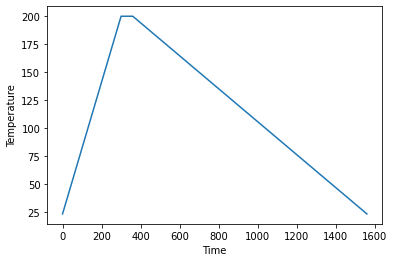

In [3]:
#@title  Read Images and Temperature Profile

datfile = "/content/drive/Shared drives/PFM/Data_for_sharing/Heating_of_BTO/Auxiliary_data_and_info/Temp_profile.dat"
datadir = "/content/drive/My Drive/Image_stack/Image_stack"
#datadir = "/content/drive/Shared drives/PFM/Data_for_sharing/Biasing_130oC/Image_stack"


sorted_filelist = sorted(os.listdir(datadir),
                         key=lambda fname: int(fname.split('.')[0][-4:]))
images = []
for i, fname in enumerate(sorted_filelist):
    print("\rImage {}/{}".format(i+1, len(sorted_filelist)), end="")
    if fname.endswith('.tif'):
        images.append(cv2.imread(os.path.join(datadir, fname), -1))
images = np.array(images)  # Assumes that all images have the same size
print("\n", images.shape)

"""Load dat file"""
dat = np.loadtxt(datfile)
print(dat.shape)
plt.plot(dat[:,0],dat[:,1])
plt.xlabel('Time')
plt.ylabel('Temperature')

#filename = "BF_90deg_domains0000.tif"
# filename = "BF_HEAT0000.tif" 

# img = cv2.imread(os.path.join(datadir, filename), -1)
# plt.imshow(img)



<function matplotlib.pyplot.show>

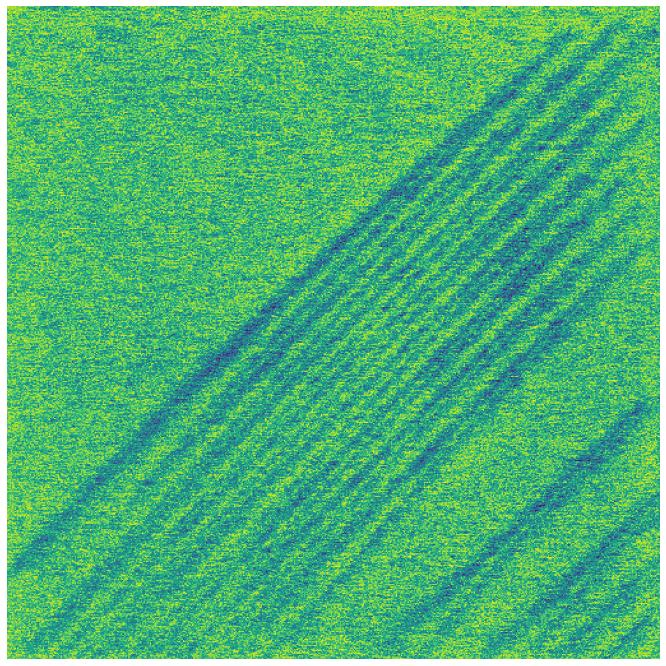

In [4]:
"""Plot images at different times"""

images = utils.cv_resize_stack(images, (512, 512)) #256
images = images/images.max()

plt.figure(figsize=(12,12))
plt.imshow(images[347]) #0 300 480 200 150 50 10
plt.axis('off')
plt.show

In [5]:
#@title Creating subimage statck using AtomAI library
np.random.seed(123)
images_input = images
num_of_subimgs = 500
imstack, com_all, frames_all = utils.extract_random_subimages(images_input, 24, num_images=num_of_subimgs) # num_images is number of images *per frame*
imstack = imstack[..., 0] # disregard channel dimension for grayscale data

d1, _, _ = images.shape
info_arr = np.zeros(([d1*num_of_subimgs ,3]))

for k in range(d1):
  for i in range(num_of_subimgs):
    info_arr[k*num_of_subimgs + i, 0], info_arr[k*num_of_subimgs + i, 1], info_arr[k*num_of_subimgs + i, 2] = k, dat[k,0], dat[k,1]

# GMM Analysis

In [6]:
from sklearn.mixture import GaussianMixture

window_size = imstack.shape[-1]
z = imstack.reshape(-1, window_size*window_size)
nc = 8 #Try 4, 8, 16, 32
gmm = GaussianMixture(n_components=nc)
gmm_predict = gmm.fit_predict(z)
np.save('class_index.npy', gmm_predict)

In [33]:
means_min, means_max = np.min(gmm.means_, axis = 1).reshape([-1,1]), np.max(gmm.means_, axis = 1).reshape([-1,1])
means = (gmm.means_ - means_min)/(means_max - means_min)

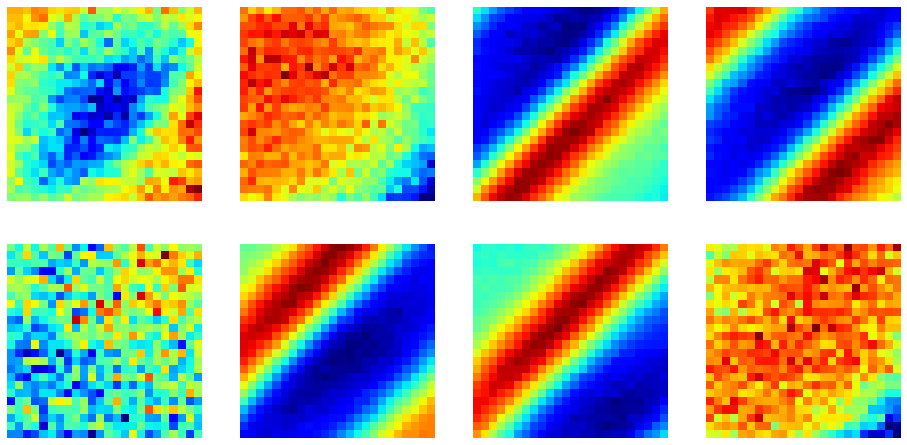

In [36]:
rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(means[i,:].reshape(window_size, window_size), cmap = 'jet') #, 
    # ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

In [31]:
np.min(gmm.means_, axis = 1)

array([0.60393375, 0.69052084, 0.55110033, 0.52417117, 0.63860295,
       0.52363846, 0.55281589, 0.66130657])

In [13]:
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde

dataGM = np.hstack((info_arr, np.expand_dims(gmm_predict, axis = 1)))
dataGM = pd.DataFrame(dataGM, columns=['Frame', 'Time', 'Temperature', 'GMM Index'])

dataGM.head()

,Frame,Time,Temperature,GMM Index
0,0.0,0.0,23.0,4.0
1,0.0,0.0,23.0,7.0
2,0.0,0.0,23.0,3.0
3,0.0,0.0,23.0,7.0
4,0.0,0.0,23.0,7.0


In [14]:
#inputs
to_analyze = ['GMM Index']
frame_col = ['Frame']

frames = np.unique(dataGM[frame_col])  #Number of different time(frame) steps
num_of_points = len(frames)  # can change the number of points here, for now we are making square images

points = np.zeros([len(to_analyze),num_of_points])  #Values' grid
pdf = np.zeros([len(to_analyze), len(frames), num_of_points])   #PDF array

limits = np.zeros(len(to_analyze))
for i, col in enumerate(to_analyze):
  # Let's get the limits here
  a = np.maximum(np.abs(np.amax(dataGM[col])), np.abs(np.amin(dataGM[col])))
  # limits[i] = 2.0*a #np.ceil(2.0*a)
  points[i] = np.linspace(-2,11, num_of_points)
  for j, frame in enumerate(frames):
    data_cons = dataGM[np.array(dataGM[frame_col] == frame)]
    kernel = gaussian_kde(data_cons[col], bw_method= 0.1)
    pdf[i, j] = kernel(points[i])

#output will be pdf of shape [a,b,c], where a corresponds to different columns analyzed
# b corresponds to the number of distinct time steps and 
# c corresponds to the number of points time axis is divided into

# limits for each column are saved in 'limits' array in the same order.

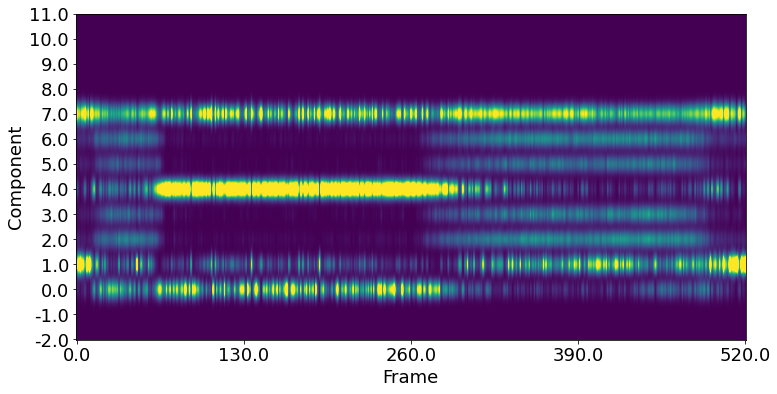

In [15]:
"""Plotting the PDFS"""
fig, ax = plt.subplots(nrows = 1, ncols = len(to_analyze), figsize = (12,6))
for i in range(len(to_analyze)):
  ax.imshow(pdf[i].T, aspect = 'auto', vmin = 0, vmax = 0.5, interpolation = 'gaussian', filterrad = 0.5)
  ax.invert_yaxis()
  ax.set_xticks((np.round(np.linspace(np.amin(frames),np.amax(frames),5))))
  ax.set_yticks((np.linspace(0,num_of_points-1,14)))

  ax.set_yticklabels(np.round(np.linspace(-2,11,14), decimals = 2), fontsize = 18)
  ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
  #plt.xticks(fontsize = 18)
  ax.set_xlabel('Frame', fontsize = 18)
  ax.set_ylabel('Component', fontsize = 18)

# Linear decomposition of PDF 

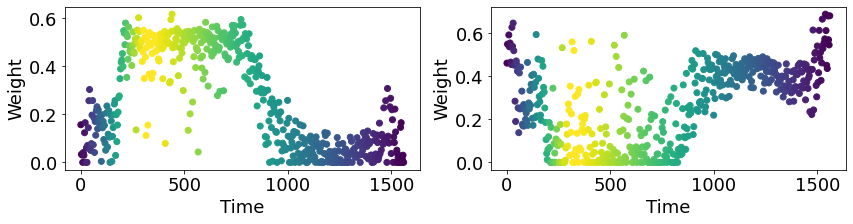

In [16]:
"""NMF"""
from sklearn.decomposition import NMF
n_comp = 2
fig, ax = plt.subplots(nrows = len(pdf), ncols = n_comp, figsize = (14,3))
components = np.zeros([len(to_analyze), n_comp, num_of_points])
i = 0

decomp = NMF(n_components = n_comp)
nmf = decomp.fit_transform(pdf[i])
components[i] = decomp.components_
for j in range(n_comp):
  ax[j].scatter(dat[:,0],nmf[:,j], c = dat[:,1]) #frames
  ax[j].set_xlabel('Time', fontsize = 18)
  ax[j].set_ylabel('Weight', fontsize = 18)
  #ax[i,j].set_xticklabels(ax[i,j].get_xticks()[::2], fontsize = 18)
  #ax[i,j].set_xticks(ax[i,j].get_xticks()[::2])
  ax[j].tick_params(axis='x', labelsize= 18)
  ax[j].tick_params(axis='y', labelsize= 18)
  #ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
  # ax[i,j].set_title('component-'+str(j+1))

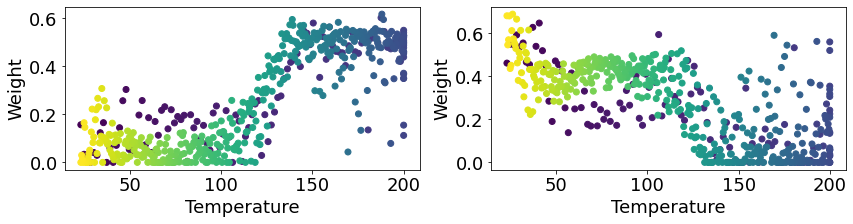

In [17]:
fig, ax = plt.subplots(nrows = len(pdf), ncols = n_comp, figsize = (14,3))
for j in range(n_comp):
  ax[j].scatter(dat[:,1],nmf[:,j], c = dat[:,0]) #frames
  ax[j].set_xlabel('Temperature', fontsize = 18)
  ax[j].set_ylabel('Weight', fontsize = 18)
  #ax[i,j].set_xticklabels(ax[i,j].get_xticks()[::2], fontsize = 18)
  #ax[i,j].set_xticks(ax[i,j].get_xticks()[::2])
  ax[j].tick_params(axis='x', labelsize= 18)
  ax[j].tick_params(axis='y', labelsize= 18)
  #ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
  # ax[i,j].set_title('component-'+str(j+1))

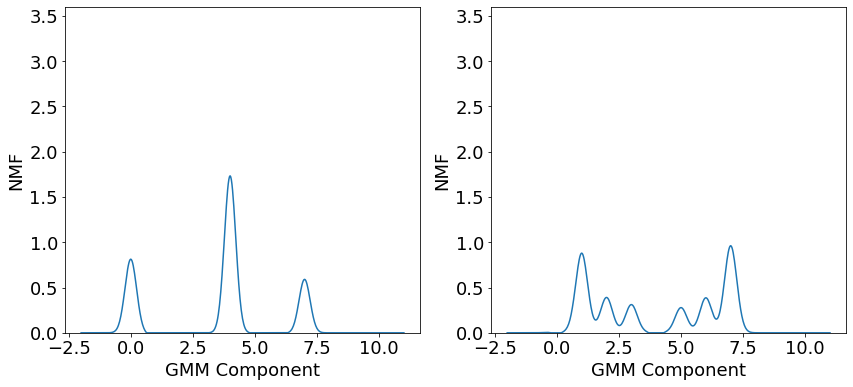

In [18]:
fig, ax = plt.subplots(nrows = len(to_analyze), ncols = n_comp, figsize = (14,6))
i = 0
for j in range(n_comp):
  ax[j].plot(points[i], components[i,j])
  ax[j].set_xlabel('GMM Component', fontsize = 18)
  ax[j].set_ylabel('NMF', fontsize = 18)
  ax[j].set_ylim((0,3.6))
  #ax[i,j].set_xticklabels(ax[i,j].get_xticks(), fontsize = 18)
  #ax[i,j].set_xticks(ax[i,j].get_xticks())
  ax[j].set_yticklabels(np.round(ax[j].get_yticks(), decimals=1), fontsize = 18)
  ax[j].tick_params(axis='x', labelsize= 18) 
  #ax[i,j].set_title('component-'+str(i+1))

# Encoding analysis

In [19]:
"""Take the images of the stack (521,512,512), 
obtain 'num_subimgs' per frame using Maxim's funciton (521*num_subimgs, window_size, window_size)
Do prescribed 'transformation on the whole matrix (521*num_subimgs, window_size*window_size)
Do prescribed linear unmixing technique on the matrix
save the weights for future use 
Do KDE analysis on the data frame"""

#theta_points is only used when transformation is radon. It is the number of points theta scale is divided into
analysis = Tileli_analysis(images_input = images, num_subimgs = 500, window_size = 24,
               transformation = 'radon', theta_points = 45, decomposition = 'pca', n_comp = 4)

analysis.encode()

Applying tansformations



  0%|          | 0/260500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
100%|██████████| 260500/260500 [11:57<00:00, 362.93it/s]


Applying linear unmixing techniques


'Encoding Done'

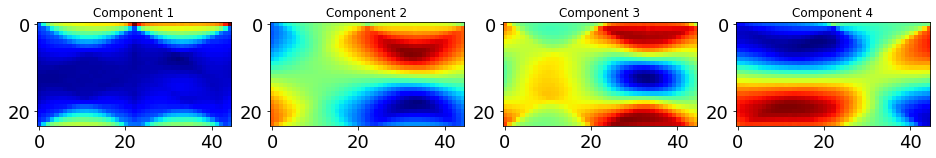

In [20]:
"""Plotting Components"""
rows,cols = 2,4
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(4):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(analysis.weights[i].reshape(24, analysis.img_dim), cmap = 'jet')      
    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
plt.show()

# KDE Analysis

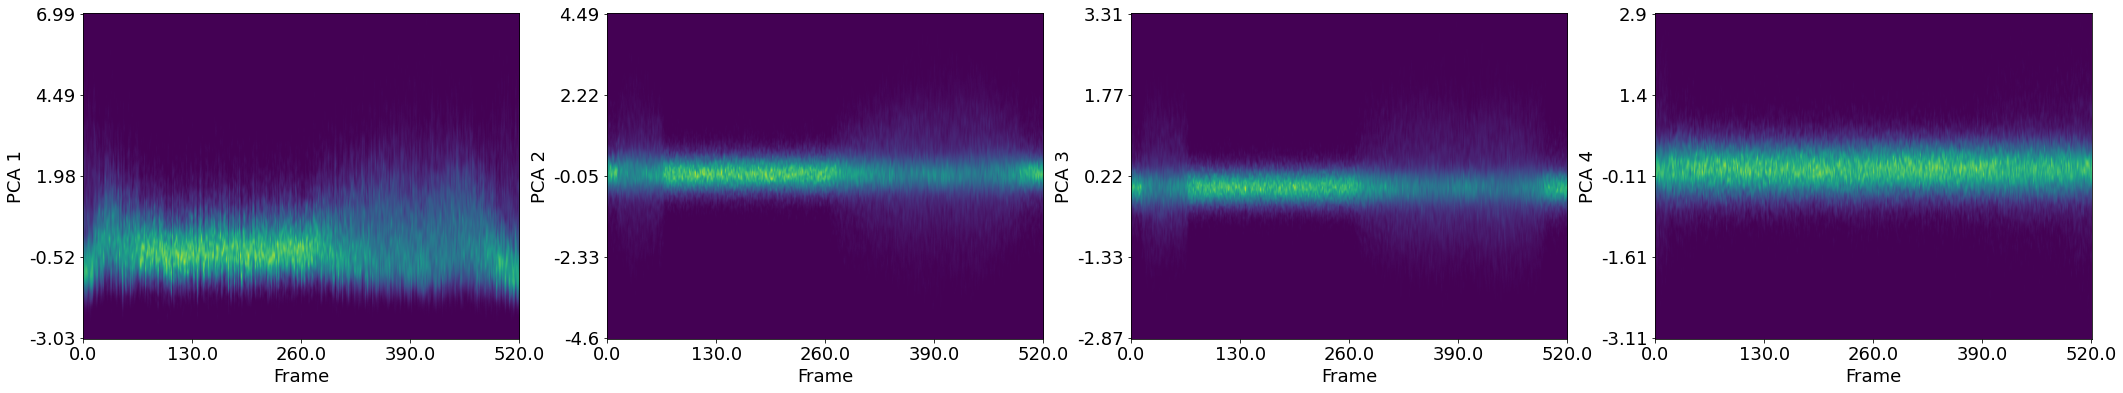

In [21]:
to_analyze = ['comp_1', 'comp_2', 'comp_3', 'comp_4']
frame_col = ['Frame']

pdf, num_of_points, limits_l, limits_t, frames, points  = do_kde(analysis.img_data, cols_to_analyze=to_analyze, frame_col = frame_col)

"""Plotting the PDFS"""
fig, ax = plt.subplots(nrows = 1, ncols = len(to_analyze), figsize = (36,6))
for i in range(len(to_analyze)):
  ax[i].imshow(pdf[i].T, aspect = 'auto', interpolation = 'gaussian', filterrad = 0.5)
  ax[i].invert_yaxis()

  ax[i].set_yticks((np.linspace(0,num_of_points-1,5)))
  ax[i].set_yticklabels(np.round(np.linspace(limits_l[i],limits_t[i],5), decimals = 2), fontsize = 18)

  ax[i].set_xticks((np.round(np.linspace(np.amin(frames),np.amax(frames),5))))
  ax[i].set_xticklabels(ax[i].get_xticks(), fontsize = 18)

  ax[i].set_xlabel('Frame', fontsize = 18)
  
  ax[0].set_ylabel('PCA 1', fontsize = 18)
  ax[1].set_ylabel('PCA 2', fontsize = 18)
  ax[2].set_ylabel('PCA 3', fontsize = 18)
  ax[3].set_ylabel('PCA 4', fontsize = 18)

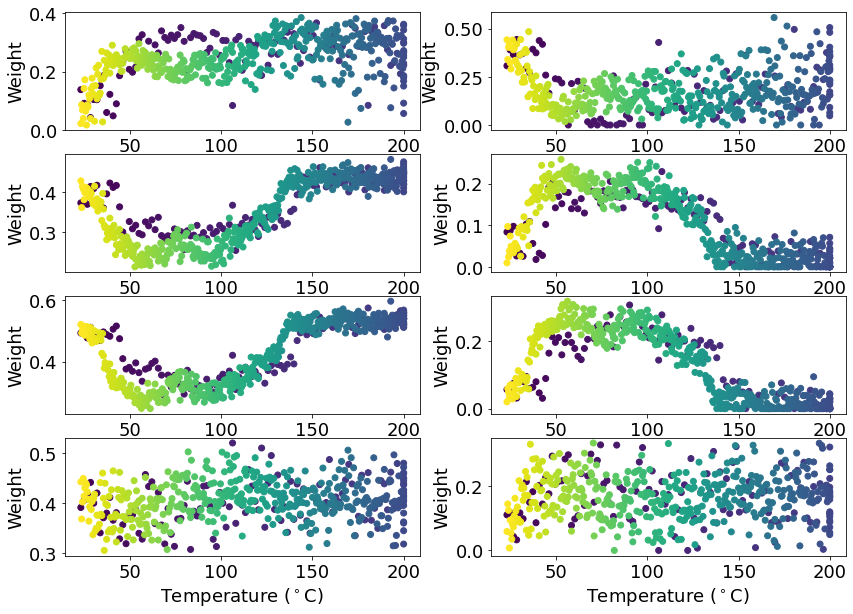

In [22]:
"""NMF on KDE"""
from sklearn.decomposition import NMF
n_comp = 2
fig, ax = plt.subplots(len(pdf), ncols = n_comp, figsize = (14,10))
components = np.zeros([len(to_analyze), n_comp, num_of_points])
for i in range(len(pdf)):
  decomp = NMF(n_components = n_comp)
  nmf = decomp.fit_transform(pdf[i])
  components[i] = decomp.components_
  for j in range(n_comp):
    ax[i,j].scatter(dat[:,1],nmf[:,j], c = dat[:,0]) #frames
    #ax[i,j].plot(dat[:,1],nmf[:,j]) #frames
    ax[i,j].set_xlabel('Temperature ($^\circ$C)', fontsize = 18)
    ax[i,j].set_ylabel('Weight', fontsize = 18)
    #ax[i,j].set_xticklabels(ax[i,j].get_xticks()[::2], fontsize = 18)
    #ax[i,j].set_xticks(ax[i,j].get_xticks()[::2])
    ax[i,j].tick_params(axis='x', labelsize= 18)
    ax[i,j].tick_params(axis='y', labelsize= 18)
    #ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
    # ax[i,j].set_title('component-'+str(j+1))

    # plt.savefig('nmf.png')

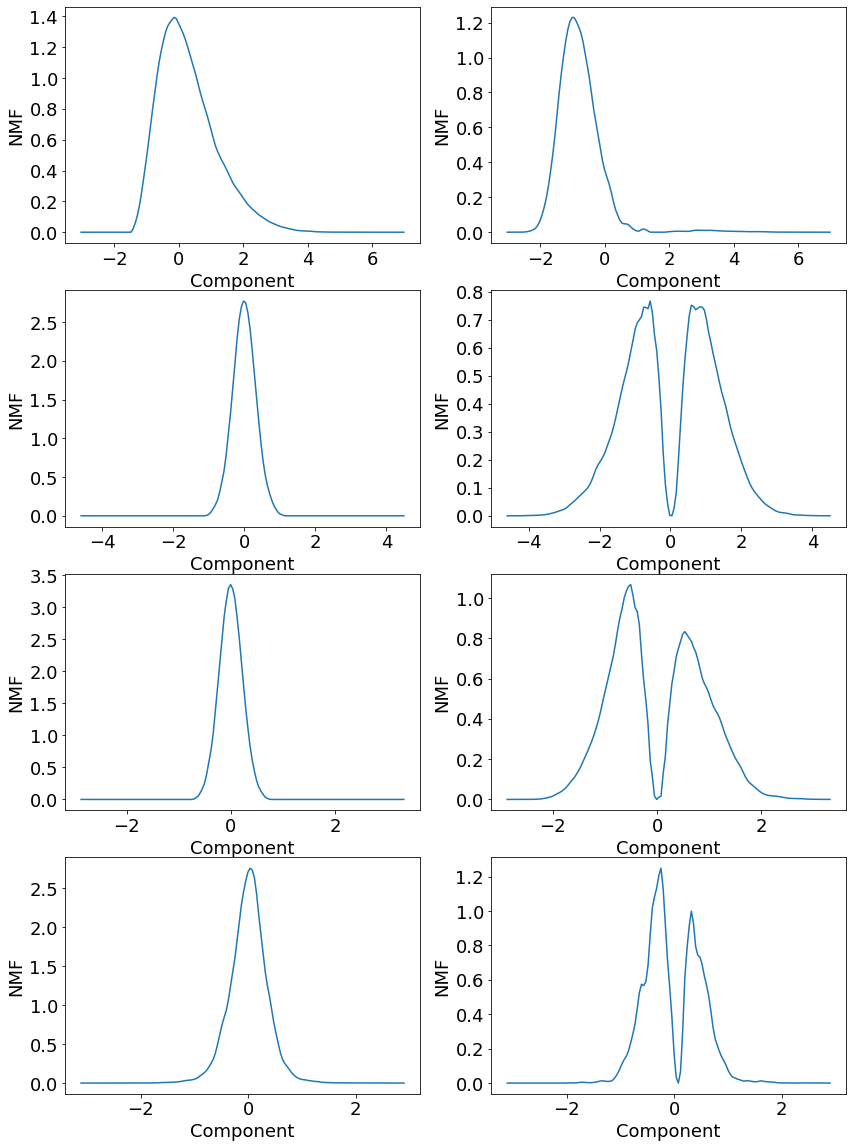

In [23]:
"""Loading Maps"""
fig, ax = plt.subplots(nrows = len(to_analyze), ncols = n_comp, figsize = (14,20))
for i in range(len(components)):
  for j in range(n_comp):
    ax[i,j].plot(points[i], components[i,j])
    ax[i,j].set_xlabel('Component', fontsize = 18)
    ax[i,j].set_ylabel('NMF', fontsize = 18)
    #ax[i,j].set_ylim((0,3.6))
    #ax[i,j].set_xticklabels(ax[i,j].get_xticks(), fontsize = 18)
    #ax[i,j].set_xticks(ax[i,j].get_xticks())
    ax[i,j].set_yticklabels(np.round(ax[i,j].get_yticks(), decimals=1), fontsize = 18)
    ax[i,j].tick_params(axis='x', labelsize= 18) 
    #ax[i,j].set_title('component-'+str(i+1))

#Decoding

In [24]:
analysis.decode(batch_update=True, num_of_frames = 4, stride = 4)
decoded = analysis.decoded

Applying tansformations



  0%|          | 0/59536 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
100%|██████████| 59536/59536 [02:45<00:00, 360.46it/s]


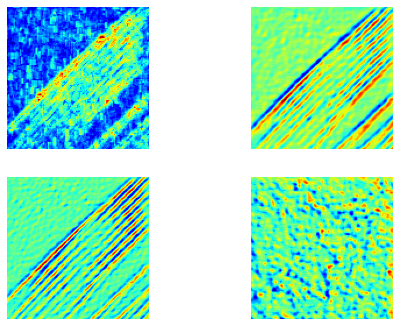

In [25]:
"""PLotting Decoded Components"""
rows,cols = 4,2
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(4): #n_comp
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(decoded[2,:,:,i], cmap = 'jet')      #window_size*theta_points
    # ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()